In [2]:
run load-clean-select.ipynb

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


Morphology was measured for 610.0 cells.

The numbers of cells and nuclei correspond to each other.

The are no duplicated column names: True
The are no duplicated column names: True
Cytoplasm measurements were taken for 610 cells.

The are no duplicated column names: True
Read biomarkers normalised by to min gain
Biomarkers were measured for 610 cells.

The are no duplicated column names: True

Full dataset has shape: (610, 484)
Initial shape is: (610, 484)
Features with zero variance:
 Index(['centerZ_cell', 'eulernumber_cell', 'children_cytoplasm_count_cell',
       'loc_centermassintensityZ_wga', 'loc_centerZ_cell',
       'loc_maxintensityZ_wga', 'centerZ_nucl', 'eulernumber_nucl',
       'children_cells_count', 'children_cytoplasm_count_nucl',
       'loc_centermassintensityZ_dapi', 'loc_centerZ_nucl',
       'loc_maxintensityZ_dapi', 'centerZ_cyto',
       'loc_centermassintensityZ_ker', 'loc_centermassintensityZ_vim',
       'loc_centerZ', 'loc_maxintensityZ_ker', 'loc_maxinten

# Which dataset?

In [3]:
# The full dataset
# df = measurements
# Dataset without clusters at 64kPa
# df = measurements_red
# Dataset without 0.5kPa, 8kPa and clusters at 64kPa
df = measurements_5
# Dataset without 0.5kPa, 8kPa and clusters at 64kPa with balanced classes
# df = measurements_b

# Some functions

In [4]:
# Prepare a vector of colours mapped to the 'stiffness' column
def create_palette(df, by='stiffness', show=False):
    if by == 'stiffness':
        n_levels = df.stiffness.unique().size
        palette = dict(zip(df.stiffness.unique(), sns.color_palette("Set3", n_levels)))
        row_colors = df.stiffness.map(palette)
    elif by == 'cluster':
        n_levels = df.cluster.unique().size
        if n_levels == 2:
            palette = {1 : sns.color_palette("PRGn", 20)[15], 2 : sns.color_palette("PRGn", 20)[4]}
        else:
            palette = dict(zip(range(n_levels), sns.color_palette("PRGn", n_levels)))
        row_colors = df.cluster.map(palette)
    elif by == 'biom':
        palette = {df.biom.unique()[0] : sns.color_palette("RdBu", 10)[1],
                   df.biom.unique()[1] : sns.color_palette("RdBu", 10)[8]}
        row_colors = df.biom.map(palette)
        
    if show:
#         print(list(palette.keys()))
        sns.palplot(palette.values());
    
    return row_colors, palette
# plt.savefig('../results/My palette.png', bbox_inches='tight', dpi=300);

In [5]:
def plot_corr(correlations, mask=False, threshold=0.9, annot=False):
    if mask:
        mask = np.zeros_like(correlations)
        mask[abs(correlations) < threshold] = 1

    plt.rcParams['figure.figsize'] = (10, 10)

    sns.heatmap(correlations, 
                mask=mask, annot=annot,
                vmin=-1, vmax=1,
                cmap=sns.color_palette("RdBu_r", 100));

In [6]:
def pca(df, cols):
    
    # Feature map
    X = df[cols]
    
    # Standartise the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Number of components requred to describe 90% variance
    pca = PCA(n_components=0.9)

    # Apply PCA to the scaled feature matrix
    X_reduced = pca.fit_transform(X_scaled)

    pc_cols = [('pc_' + str(i)) for i in range(1, X_reduced.shape[1] + 1)]
    pc_df = pd.concat([df.loc[:, ['label', 'stiffness', 'cluster']],
                      pd.DataFrame(data = X_reduced, columns = pc_cols)], 
                      axis=1)

    print("The first {} components explain 90% of variance.\n".format(pca.n_components_ ))

    print("Explained variance: {}\n".format(pca.explained_variance_ratio_))

    print(X.shape, pca.components_.shape, X_reduced.shape, pc_df.shape)
    
    return pc_df

# PCA on geometric features

In [7]:
pc_df = pca(df, geom_cols)

The first 53 components explain 90% of variance.

Explained variance: [0.13912965 0.07059385 0.05803451 0.04763031 0.04579563 0.03897969
 0.03212858 0.02352711 0.0222417  0.02068055 0.02004868 0.01861215
 0.0178068  0.01666179 0.01599674 0.01522207 0.01473968 0.01330807
 0.01271776 0.01230694 0.01221731 0.0113584  0.01123845 0.01079213
 0.0105415  0.0100552  0.00981331 0.0096551  0.00901757 0.00880442
 0.00833257 0.00826972 0.00813014 0.00782057 0.0074645  0.0073428
 0.00714909 0.0070417  0.00672042 0.00636841 0.006171   0.00608958
 0.00605282 0.00584163 0.00568904 0.00547753 0.0052653  0.00506151
 0.00491247 0.00477484 0.00468824 0.00452231 0.00441575]

(460, 116) (53, 116) (460, 53) (460, 56)


/Applications/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


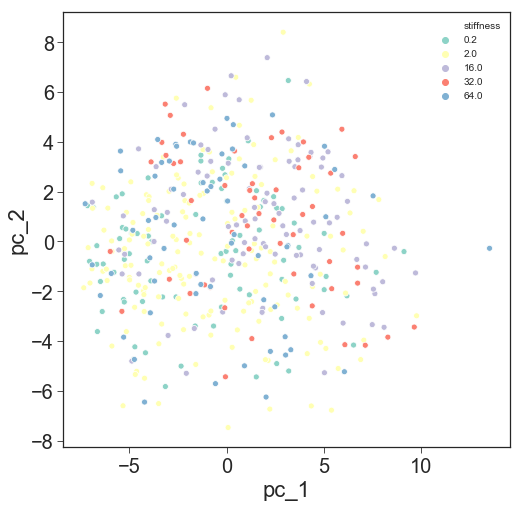

In [8]:
plt.rc("figure", figsize=(8, 8))

row_colors, palette = create_palette(df, by='stiffness')

sns.scatterplot(x='pc_1', y='pc_2', data=pc_df, 
                hue='stiffness', palette=palette);

# Hierarchical clustering

In [9]:
# Features to use
cols = geom_cols

print(df[cols].shape)

(460, 116)


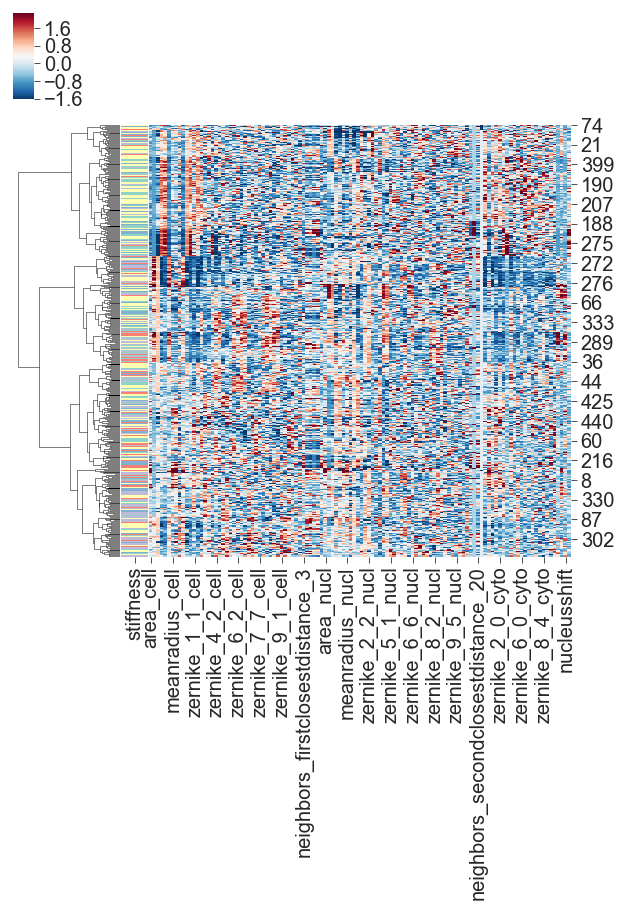

In [10]:
X = df[cols]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

row_colors, palette = create_palette(df)

sns.clustermap(pd.DataFrame(X_scaled, columns=cols), 
               metric='euclidean', method='ward',
               col_cluster=False,
               cmap=sns.color_palette('RdBu_r', 100), robust=True, 
               row_colors=row_colors);

# plt.savefig('../results/Clustering syn.png', bbox_inches='tight', dpi=300);

# Define subpopulations

## How many subpopulations?

In [11]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from s_dbw import SD
X = df[cols]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

silhouette = []
ch_score = []
db_score = []
sd_score = []

cluster_range = range(2, 10)
for n_clusters in cluster_range:
    agg = AgglomerativeClustering(n_clusters=n_clusters)
    agg.fit(X_scaled)
    silhouette.append(silhouette_score(X_scaled, agg.labels_, metric='euclidean'))
    ch_score.append(calinski_harabasz_score(X_scaled, agg.labels_))
    db_score.append(davies_bouldin_score(X_scaled, agg.labels_))
    sd_score.append(SD(X_scaled, agg.labels_))

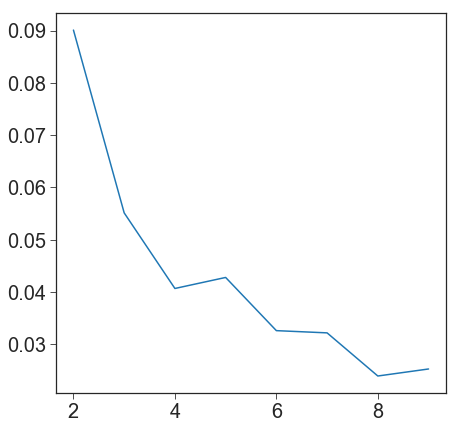

In [12]:
plt.rcParams['figure.figsize'] = (7, 7)
# Higher is better
plt.plot(cluster_range, silhouette);

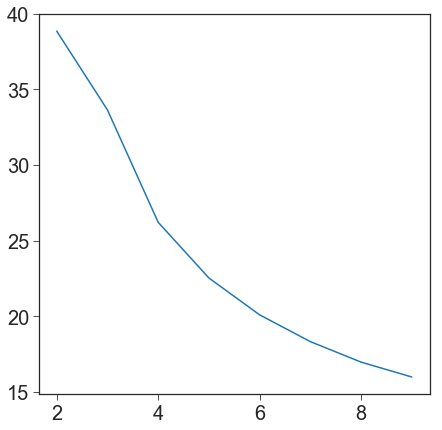

In [13]:
# Higher is better
plt.plot(cluster_range, ch_score);

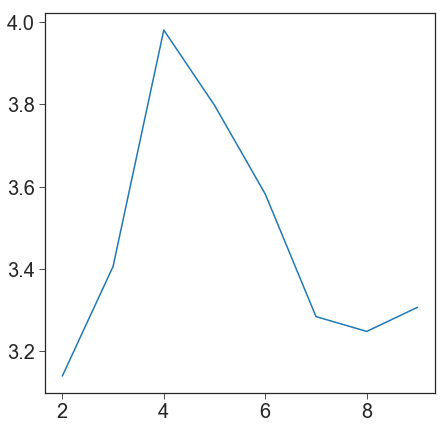

In [14]:
# Zero is better
plt.plot(cluster_range, db_score);

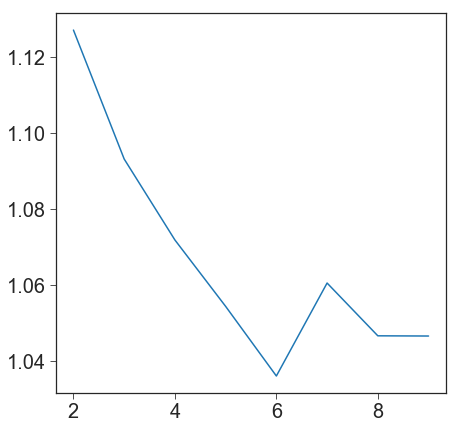

In [15]:
# Lower is better
plt.plot(cluster_range, sd_score);

## Visualise subpopulations

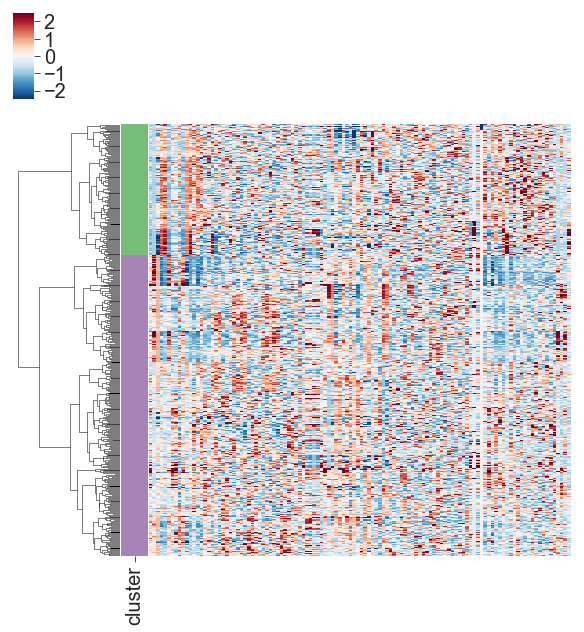

In [16]:
X = df[cols]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

n_clusters = 2
agg = AgglomerativeClustering(n_clusters=n_clusters)
agg.fit(X_scaled) 

# 1 is epit, 0 => 2 is mesench
if n_clusters == 2:
    df['cluster'] = np.where(agg.labels_ == 1, 1, 2)
else:
    df['cluster'] = agg.labels_

row_colors, palette = create_palette(df, by='cluster')

# Cluster map
sns.clustermap(pd.DataFrame(X_scaled, columns=cols), 
               metric='euclidean', method='ward',
               col_cluster=False,
               cmap=sns.color_palette('RdBu_r', 100), 
               vmin=-2.5, vmax=2.5,
               robust=True, row_colors=row_colors, 
#                figsize=(6.5, 10), 
               xticklabels=False, yticklabels=False);


plt.savefig('../results/Clustering geom_cols.png', bbox_inches='tight', dpi=300);

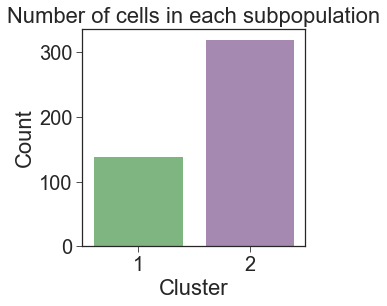

In [17]:
# Number of observations in each cluster
plt.rcParams['figure.figsize'] = (4, 4)
sns.countplot(x="cluster", data=df, palette=palette);
plt.xlabel("Cluster");
plt.ylabel("Count");
plt.title("Number of cells in each subpopulation");

In [83]:
df.groupby('cluster').size()

cluster
1    140
2    320
dtype: int64

## Distribution of clusters

### Simple proportion:
** Proportion of cells of each cluster to total cell number per stiffness**

In [18]:
counts = df.groupby('stiffness').cluster.value_counts().unstack()
cluster_cols = ['cluster'+ str(n+1) for n in range(n_clusters)]
counts.columns = cluster_cols
counts['total'] = df.groupby('stiffness').size()
for col in cluster_cols:
    counts[col] = counts[col] / counts.total * 100
counts

,cluster1,cluster2,total
stiffness,,,
0.2,43.373494,56.626506,83
2.0,40.123457,59.876543,162
16.0,13.402062,86.597938,97
32.0,12.727273,87.272727,55
64.0,30.158730,69.841270,63


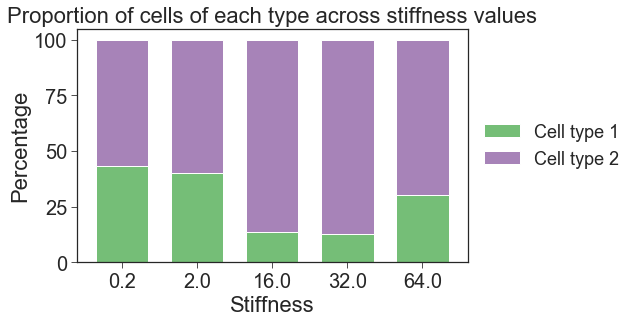

In [19]:
counts.iloc[:, 0 : n_clusters].plot(kind='bar', width=0.7, 
                                    stacked=True, 
                                    color=palette.values(), 
                                    figsize=(7, 4.3));

plt.xticks(rotation='horizontal')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=18, labels=('Cell type 1', 'Cell type 2'));
plt.xlabel("Stiffness");
plt.ylabel("Percentage");
plt.title("Proportion of cells of each type across stiffness values");
# plt.savefig('../results/Clusters geom_cols.png', bbox_inches='tight', dpi=300);

### Add confidence intervals for proportions
** For two clusters only**

In [20]:
if n_clusters > 2:
    print("Error, check maths!")
else:
    counts['err'] = 1.96 * np.sqrt(counts.cluster1 * counts.cluster2 / counts.total)

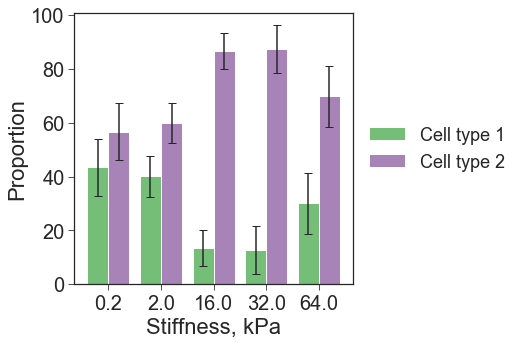

In [21]:
counts.loc[:, ['cluster1', 'cluster2']].plot(kind='bar', width=0.8, 
                                             yerr=counts.err, capsize=4,
                                             color=palette.values(), 
                                             figsize=(5, 5));

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=18, labels=('Cell type 1', 'Cell type 2'));
plt.xticks(rotation='horizontal')
plt.xlabel("Stiffness, kPa");
plt.ylabel("Proportion");
# plt.title("Proportion of cells of each type across stiffness values");
plt.savefig('../results/Clusters geom_cols.png', bbox_inches='tight', dpi=300);

### Distribution of clusters across images and stiffness values

In [ ]:
counts = df.groupby(['stiffness', 'image']).cluster.value_counts().unstack().fillna(0)
counts.columns = ['cluster 1', 'cluster 2']
counts['total'] = df.groupby(['stiffness', 'image']).size()
counts['p'] = counts['cluster 1'] / counts.total * 100
counts['1-p'] = counts['cluster 2'] / counts.total * 100
counts.head()

In [ ]:
counts.reset_index(inplace=True)
counts = pd.melt(counts, id_vars=['stiffness'], value_vars=['p', '1-p'])
counts.head()

In [ ]:
plt.rcParams['figure.figsize'] = (4, 6)

row_colors, palette = create_palette(df, by='cluster')

sns.barplot(x='stiffness', y='value', 
            hue='variable', data=counts,
            ci=95, capsize=.1, 
            palette=palette.values());
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=18);
plt.xlabel("Stiffness, kPa");
plt.ylabel("Proportion");
plt.ylim([0, 119]);
# plt.title("Distribution of cell types across stiffness values");
plt.savefig('../results/Clusters geom_cols.png', bbox_inches='tight', dpi=300);

# An average "cell" of each cluster

In [ ]:
df_scaled = pd.concat([df.loc[:, ['label', 'stiffness', 'cluster']], 
                       pd.DataFrame(data = X_scaled, columns = cols)], axis=1)

In [ ]:
cell1 = df_scaled.loc[df_scaled.cluster == 1, cols].mean()
cell2 = df_scaled.loc[df_scaled.cluster == 2, cols].mean()

In [ ]:
from sklearn.metrics import pairwise_distances

dist1 = pairwise_distances(df_scaled[cols], cell1.values.reshape(1, -1))
dist2 = pairwise_distances(df_scaled[cols], cell2.values.reshape(1, -1))
# dist.argmax() - df.shape[0]*(dist.argmax()//df.shape[0])
dist1.argmin(), dist2.argmin()

In [ ]:
df.iloc[[dist1.argmin(), dist2.argmin()]]

# Within-cluster variability

In [ ]:
df_scaled = pd.concat([df.loc[:, ['label', 'stiffness', 'cluster']], 
                       pd.DataFrame(data = X_scaled, columns = cols)], axis=1)

In [ ]:
from sklearn.metrics import pairwise_distances

dist1 = pairwise_distances(df_scaled.loc[df_scaled.cluster == 1, cols])
dist2 = pairwise_distances(df_scaled.loc[df_scaled.cluster == 2, cols])
dist = pairwise_distances(df_scaled[cols])
dist1.argmax(), dist2.argmax(), dist.argmax()

# Determine most important features

In [22]:
X = df[cols]
y = df.cluster
 
# Create train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

rf_clf = RandomForestClassifier()

Training set size: (414, 116)
Test set size: (46, 116)


In [ ]:
# best_rf_clf = rf.random_search_param(rf_clf, X_train, y_train)

** Save the best estimator **

In [ ]:
joblib.dump(best_rf_clf, 'models/geom-to-cluster-clf.pkl')

In [23]:
best_rf_clf = joblib.load('models/geom-to-cluster-clf.pkl')

In [24]:
rf.train_test(best_rf_clf, 0, X_train, X_test, y_train, y_test)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=100, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=1600,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False) 


Number of observations of each class in the training set:
 2    293
1    121
Name: cluster, dtype: int64

Number of observations of each class in the test set:
 2    27
1    19
Name: cluster, dtype: int64

Null accuraccy: 0.5869565217391305
Testing accuraccy: 0.9130434782608695
Testing f-score: 0.9066937119675456
    1   2
1  15   4
2   0  27


Important features
                  feature    weight
5   majoraxislength_cell  0.110753
4        formfactor_cell  0.092584
9         perimeter_cell  0.091767
10         solidity_cell  0.071687
3            extent_cell  0.065217
1       compactness_cell  0.056981
11      zernike_0_0_cell  0.055919
0              area_cell  0.033680
13      zernike_2_0_cell  0.028997
2      eccentricity_cell  0.027053
98      zernike_4_0_cyto  0.026117
92       formfactor_cyto  0.024456


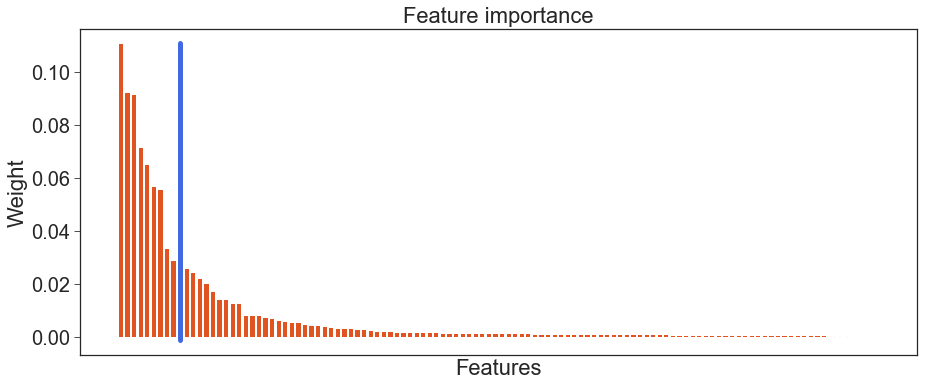

In [25]:
important_features = rf.get_important_features(best_rf_clf, X.columns)

###### New observations

In [26]:
y_pred = best_rf_clf.predict(clumped[cols])
y_pred

array([2, 2, 2, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2,
       2])

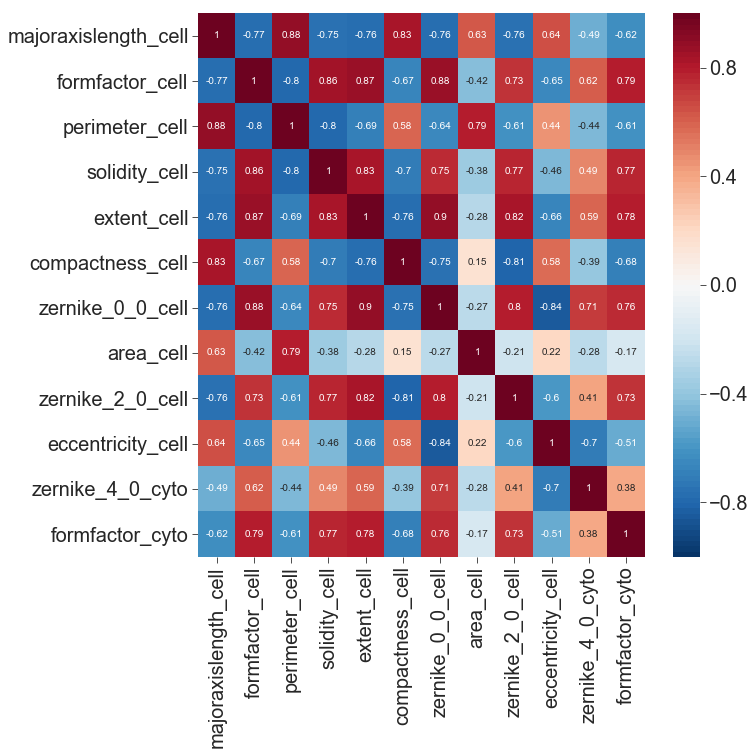

In [27]:
plot_corr(df[important_features.feature].corr(), mask=False, threshold=0.8, annot=True)

## Boxplots of most important features

In [28]:
def px_to_um(x):
    return x * 0.2076

In [29]:
def stat_tests(col, boxcox=False):

    tmp = df[['cluster', col]]
    
    if boxcox:
        # Box-Cox transformation
        from sklearn.preprocessing import PowerTransformer
        X = tmp[col].values.reshape(-1, 1)
        powertf = PowerTransformer(copy=False)
        powertf.fit(X)
        tmp[col] = powertf.transform(X)
    
    # Welch's t-test
    w_stat, w_p = stats.ttest_ind(tmp.loc[tmp.cluster == 1, col], 
                                  tmp.loc[tmp.cluster == 2, col], 
                                  equal_var=False)
    # Mann-Whitney U test
    u_stat, u_p = stats.mannwhitneyu(tmp.loc[tmp.cluster == 1, col], 
                                     tmp.loc[tmp.cluster == 2, col])
    
    print("Welch's t-test")
    print("statistic: {}, p-value: {}".format(w_stat, w_p))
    print("\nMann-Whitney U test")
    print("statistic: {}, p-value: {}".format(u_stat, u_p))

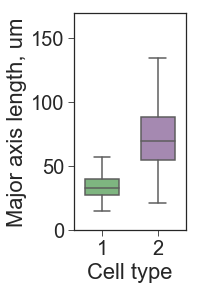

In [30]:
plt.rcParams['figure.figsize'] = (2, 4)
sns.boxplot(x=df.cluster, y=px_to_um(df[important_features.iloc[0, 0]]), 
            width=0.6, palette=palette, showfliers=False);

plt.ylim([0, 170]);
plt.xlabel("Cell type");
plt.ylabel("Major axis length, um");
plt.savefig('../results/majoraxislength per cluster.png', bbox_inches='tight', dpi=300);

In [31]:
stat_tests(important_features.iloc[0, 0], boxcox=True)

Welch's t-test
statistic: -24.38316959550479, p-value: 4.91240636049302e-77

Mann-Whitney U test
statistic: 1980.0, p-value: 6.303625185496588e-55


/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


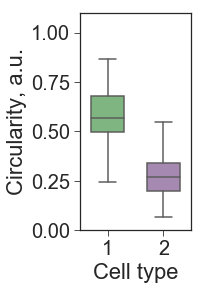

In [32]:
sns.boxplot(x=df.cluster, y=df[important_features.iloc[1, 0]], 
            width=0.6, palette=palette, showfliers=False);

plt.ylim([0, 1.1]);
plt.xlabel("Cell type");
plt.ylabel("Circularity, a.u.");
plt.savefig('../results/circularity per cluster.png', bbox_inches='tight', dpi=300);

In [33]:
stat_tests(important_features.iloc[1, 0])

Welch's t-test
statistic: 22.325505069649672, p-value: 6.1973749815792555e-58

Mann-Whitney U test
statistic: 2510.0, p-value: 3.2091268433430636e-52


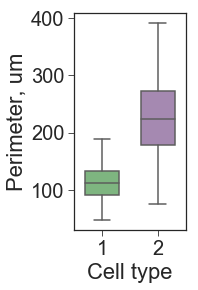

In [34]:
sns.boxplot(x=df.cluster, y=px_to_um(df[important_features.iloc[2, 0]]), 
            width=0.6, palette=palette, showfliers=False);

# plt.ylim([0, 480]);
plt.xlabel("Cell type");
plt.ylabel("Perimeter, um");
plt.savefig('../results/perimeter per cluster.png', bbox_inches='tight', dpi=300);

In [35]:
stat_tests(important_features.iloc[2, 0])

Welch's t-test
statistic: -21.676363846532283, p-value: 5.021629373958708e-72

Mann-Whitney U test
statistic: 2609.0, p-value: 1.0096530459832656e-51


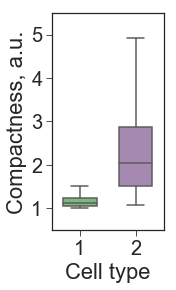

In [36]:
plt.rcParams['figure.figsize'] = (2, 4)
sns.boxplot(x=df.cluster, y=df.compactness_cell, 
            width=0.6, palette=palette, showfliers=False);

plt.ylim([0.5, 5.5]);
plt.xlabel("Cell type");
plt.ylabel("Compactness, a.u.");
plt.savefig('../results/compactness per cluster.png', bbox_inches='tight', dpi=300);

In [37]:
stat_tests('compactness_cell', boxcox=True)

Welch's t-test
statistic: -24.0726590370971, p-value: 1.6364444535233698e-82

Mann-Whitney U test
statistic: 2796.0, p-value: 8.663919080142562e-51


/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


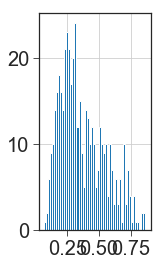

In [38]:
df.formfactor_cell.hist(bins=50);

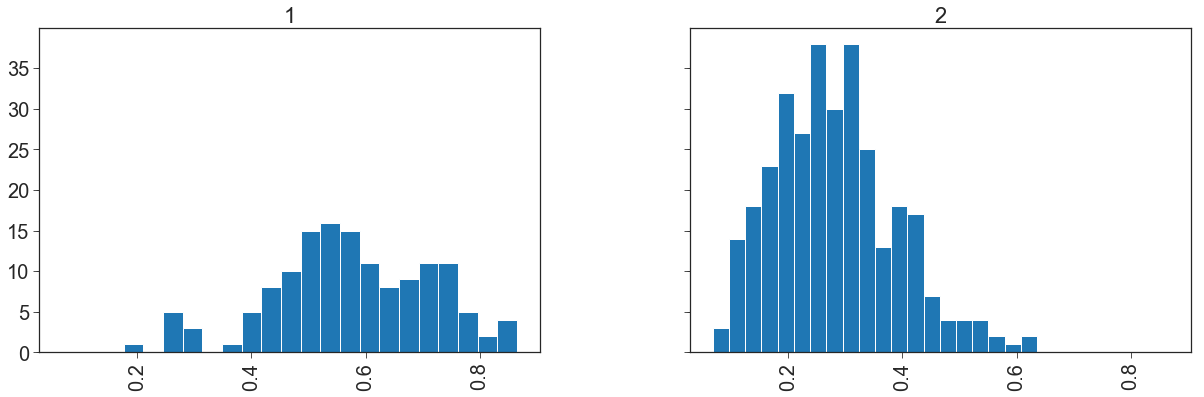

In [39]:
df.hist(column='formfactor_cell', by='cluster', bins=20, 
                sharex=True, sharey=True, 
                layout=(1, 2), figsize=(20, 6));

# PCA to visualise subpopulations

In [40]:
pc_df = pca(df, important_features.feature)

The first 4 components explain 90% of variance.

Explained variance: [0.67864328 0.11294575 0.0821974  0.04500541]

(460, 12) (4, 12) (460, 4) (460, 7)


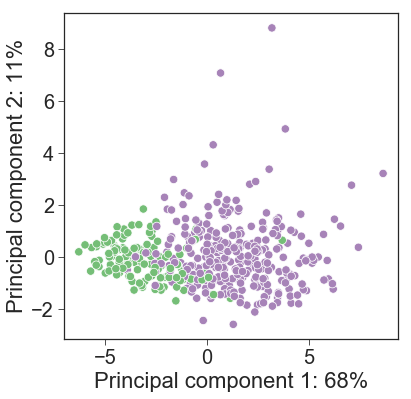

In [41]:
plt.rc("figure", figsize=(6, 6))

row_colors, palette = create_palette(df, by='cluster')

sns.scatterplot(x='pc_1', y='pc_2', data=pc_df, s=70,
                hue='cluster', palette=palette, legend=None);

plt.xlabel("Principal component 1: 68%");
plt.ylabel("Principal component 2: 11%");
plt.savefig('../results/pca on imp features.png', bbox_inches='tight', dpi=300);

## Find two cells furthest away from each other

In [ ]:
from sklearn.metrics import pairwise_distances

dist = pairwise_distances(X_reduced)

dist.argmax() - df.shape[0]*(dist.argmax()//df.shape[0])

In [ ]:
pc_df.loc[pc_df.pc_1 < -5.5]

In [ ]:
pc_df.loc[pc_df.pc_1 > 7]

## PCA stiffness against cluster

In [ ]:
plt.rc("figure", figsize=(8, 8))

centroids = pc_df.groupby('stiffness')[['pc_1', 'pc_2']].mean().reset_index()

row_colors, palette = create_palette(df, by='stiffness')
sns.scatterplot(x='pc_1', y='pc_2', data=pc_df, 
                style='cluster', markers=['o', 's'],
                hue='stiffness', palette=palette);

sns.scatterplot(x="pc_1", y="pc_2", data=centroids, 
                hue='stiffness', palette=palette, 
                s=200, marker='X', edgecolor='black', 
                legend=None);

# Relationship to biomarkers

## Correlations with biom features

maxintdisplacement_ker    0.364139
massdisplacement_ker      0.332959
massdisplacement_vim      0.317577
maxintdisplacement_vim    0.309198
infomeas1_ker_01          0.286410
ctcf_vim                  0.263882
infomeas1_ker_00          0.261517
infomeas1_ker_03          0.253937
infomeas1_ker_02          0.237783
stdintensity_vim          0.228293
dtype: float64


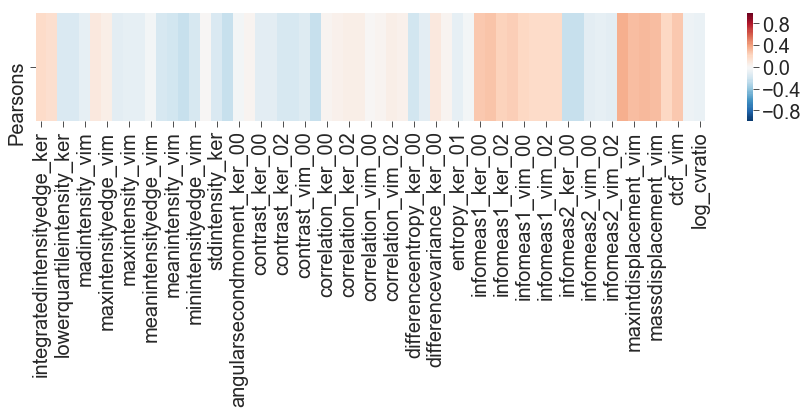

In [42]:
p_corr = df[biom_cols].corrwith(df.cluster)

print(p_corr.abs().sort_values(ascending=False).head(10))

plt.rcParams['figure.figsize'] = (15, 2)

sns.heatmap(pd.DataFrame(p_corr, columns=['Pearsons']).T, 
            cmap=sns.color_palette("RdBu_r", 100), 
            vmin=-1, vmax=1);

### Mass displacement

** Show on a single plot**

In [43]:
tmp = pd.melt(df[['stiffness', 'cluster', 'massdisplacement_ker', 'massdisplacement_vim']],
              id_vars=['stiffness', 'cluster'],
              value_vars=['massdisplacement_ker', 'massdisplacement_vim'], 
              var_name='biom', value_name='massdisp')

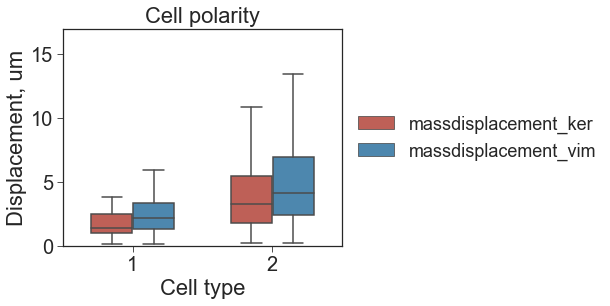

In [44]:
plt.rcParams['figure.figsize'] = (5, 4)

row_colors, palette = create_palette(tmp, 'biom')

sns.boxplot(x=tmp.cluster, y=px_to_um(tmp.massdisp), 
            hue=tmp.biom, palette=palette,
            width=0.6, showfliers=False);

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=18);
plt.ylim([0, 17]);
plt.xlabel("Cell type");
plt.ylabel("Displacement, um");
plt.title("")
plt.savefig('../results/massdisp per cluster.png', bbox_inches='tight', dpi=300);

** Separate plots and statistical testing**

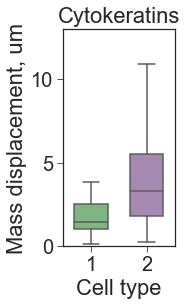

In [45]:
plt.rcParams['figure.figsize'] = (2, 4)

row_colors, palette = create_palette(df, by='cluster')

sns.boxplot(x=df.cluster, y=px_to_um(df.massdisplacement_ker), 
            width=0.6, palette=palette, showfliers=False);

plt.ylim([0, 13]);
plt.xlabel("Cell type");
plt.ylabel("Mass displacement, um");
plt.title("Cytokeratins")
plt.savefig('../results/massdisp ker per cluster.png', bbox_inches='tight', dpi=300);

In [46]:
stat_tests('massdisplacement_ker')

Welch's t-test
statistic: -9.342665833482574, p-value: 4.945068746515215e-19

Mann-Whitney U test
statistic: 11620.0, p-value: 1.0455116114512007e-16


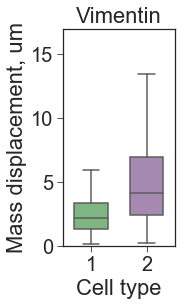

In [47]:
plt.rcParams['figure.figsize'] = (2, 4)
sns.boxplot(x=df.cluster, y=px_to_um(df.massdisplacement_vim), 
            width=0.6, palette=palette, showfliers=False);

plt.ylim([0, 17]);
plt.xlabel("Cell type");
plt.ylabel("Mass displacement, um");
plt.title("Vimentin");
plt.savefig('../results/massdisp vim per cluster.png', bbox_inches='tight', dpi=300);

In [48]:
stat_tests('massdisplacement_vim')

Welch's t-test
statistic: -9.000698053197935, p-value: 6.592190220768351e-18

Mann-Whitney U test
statistic: 12561.0, p-value: 3.2040424603895857e-14


## CTCF of ker and vim

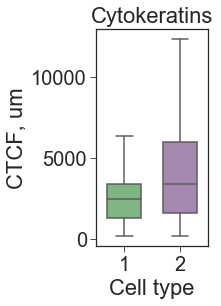

In [49]:
plt.rcParams['figure.figsize'] = (2, 4)

row_colors, palette = create_palette(df, by='cluster')

sns.boxplot(x=df.cluster, y=df.ctcf_ker, 
            width=0.6, palette=palette, showfliers=False);
# plt.figure()
# sns.barplot(x=df.cluster, y=df.ctcf_ker, 
#             ci=95, capsize=.1, palette=palette);

# plt.ylim([0, 13]);
plt.xlabel("Cell type");
plt.ylabel("CTCF, um");
plt.title("Cytokeratins");
plt.savefig('../results/ker per cluster.png', bbox_inches='tight', dpi=300);

In [50]:
stat_tests('ctcf_ker')

Welch's t-test
statistic: -5.778085451288176, p-value: 1.4067305001606298e-08

Mann-Whitney U test
statistic: 17347.0, p-value: 5.874596328451232e-05


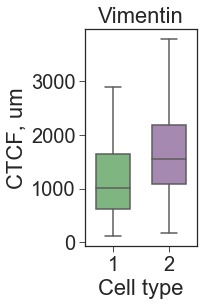

In [51]:
plt.rcParams['figure.figsize'] = (2, 4)

row_colors, palette = create_palette(df, by='cluster')

sns.boxplot(x=df.cluster, y=df.ctcf_vim, 
            width=0.6, palette=palette, showfliers=False);
# plt.figure()
# sns.barplot(x=df.cluster, y=df.ctcf_vim, 
#             ci=95, capsize=.1, palette=palette);

# plt.ylim([0, 13]);
plt.xlabel("Cell type");
plt.ylabel("CTCF, um");
plt.title("Vimentin");
plt.savefig('../results/vim per cluster.png', bbox_inches='tight', dpi=300);

In [52]:
stat_tests('ctcf_vim')

Welch's t-test
statistic: -6.600060200205166, p-value: 1.4927373753409788e-10

Mann-Whitney U test
statistic: 14026.0, p-value: 8.696500036236565e-11


## CV ratio

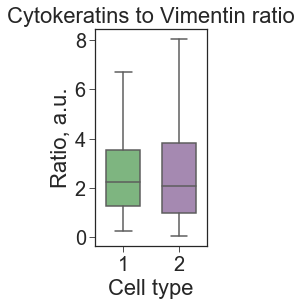

In [59]:
plt.rcParams['figure.figsize'] = (2, 4)

row_colors, palette = create_palette(df, by='cluster')

sns.boxplot(x=df.cluster, y=df.cvratio, 
            width=0.6, palette=palette, showfliers=False);
# plt.figure()
# sns.barplot(x=df.cluster, y=df.cvratio, 
#             ci=95, capsize=.1, palette=palette);

# plt.ylim([0, 13]);
plt.xlabel("Cell type");
plt.ylabel("Ratio, a.u.");
plt.title("Cytokeratins to Vimentin ratio");
plt.savefig('../results/CVR per cluster.png', bbox_inches='tight', dpi=300);

In [60]:
stat_tests('cvratio')

Welch's t-test
statistic: 0.9546953848974061, p-value: 0.34071206770857776

Mann-Whitney U test
statistic: 20874.0, p-value: 0.12245079643000173


## Regions of biomarker levels

In [61]:
df['region'] = "00"
df.loc[(df.ctcf_ker < df.ctcf_ker.median()) & (df.ctcf_vim > df.ctcf_vim.median()), 'region'] = "01"
df.loc[(df.ctcf_ker > df.ctcf_ker.median()) & (df.ctcf_vim < df.ctcf_vim.median()), 'region'] = "10"
df.loc[(df.ctcf_ker > df.ctcf_ker.median()) & (df.ctcf_vim > df.ctcf_vim.median()), 'region'] = "11"

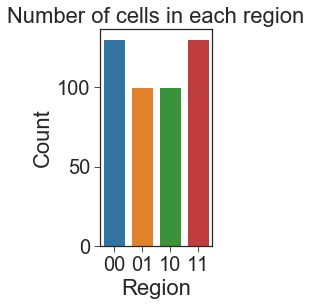

In [62]:
# Number of observations in each region
sns.countplot(x="region", data=df);
plt.xlabel("Region");
plt.ylabel("Count");
plt.title("Number of cells in each region");

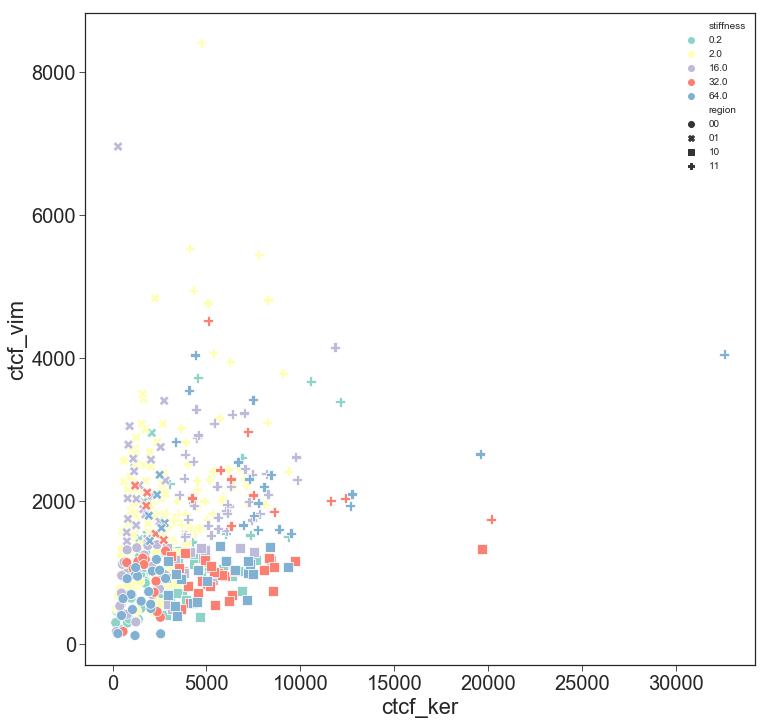

In [76]:
plt.rcParams['figure.figsize'] = (12, 12)

sns.scatterplot(x='ctcf_ker', y='ctcf_vim', data=df,
                hue='stiffness', style='region', s=100,
                palette=sns.color_palette("Set3", 5));

In [77]:
df.groupby(['stiffness', 'region']).size()

stiffness  region
0.2        00        33
           01        10
           10        27
           11        13
2.0        00        41
           01        57
           10        11
           11        53
16.0       00        24
           01        22
           10        16
           11        35
32.0       00        13
           01         5
           10        26
           11        11
64.0       00        19
           01         6
           10        20
           11        18
dtype: int64

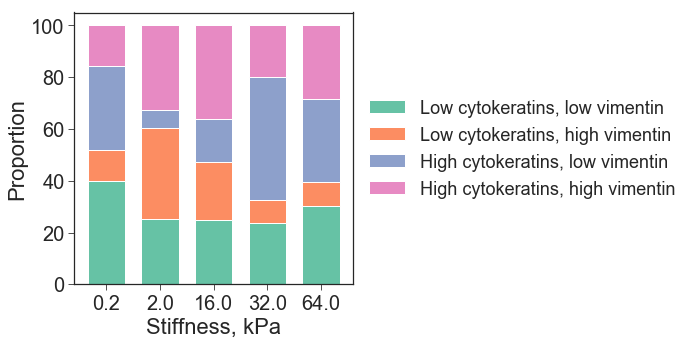

In [82]:
plt.rcParams['figure.figsize'] = (5, 5)

tmp = df.groupby(['stiffness', 'region']).size().unstack()

tmp['total'] = df.groupby('stiffness').size()

tmp['00'] = tmp['00'] / tmp.total * 100
tmp['01'] = tmp['01'] / tmp.total * 100
tmp['10'] = tmp['10'] / tmp.total * 100
tmp['11'] = tmp['11'] / tmp.total * 100

tmp.iloc[:, 0 : 4].plot(kind='bar', width=0.7, stacked=True, color=sns.color_palette("Set2", 4));


plt.xticks(rotation='horizontal')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=18, 
           labels=('Low cytokeratins, low vimentin', 
                   'Low cytokeratins, high vimentin', 
                   'High cytokeratins, low vimentin', 
                   'High cytokeratins, high vimentin'));
plt.xlabel("Stiffness, kPa");
plt.ylabel("Proportion");
# plt.title("Proportion of cells of each type across stiffness values");

In [ ]:
df.groupby(['stiffness', 'cluster']).ctcf_ker.mean()

In [ ]:
df.groupby(['stiffness', 'cluster']).ctcf_vim.median()

In [ ]:
plt.rcParams['figure.figsize'] = (6, 4)
sns.barplot(x='stiffness', y='ctcf_ker', 
            hue='cluster', data=df,
            ci='sd', capsize=.1,
#             showfliers=False,
            palette=palette.values());

In [ ]:
sns.barplot(x='stiffness', y='ctcf_vim', 
            hue='cluster', data=df,
            ci=95, capsize=.1,
#             showfliers=False,
            palette=palette.values());

In [ ]:
sns.boxplot(x=df.stiffness, y=df.massdisplacement_vim, width = 0.6, showfliers=False);